In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


!pip install opencv-python-headless scikit-image matplotlib numpy

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import exposure, filters, morphology, util

# **Image Pre-processing code for LIVECELL**

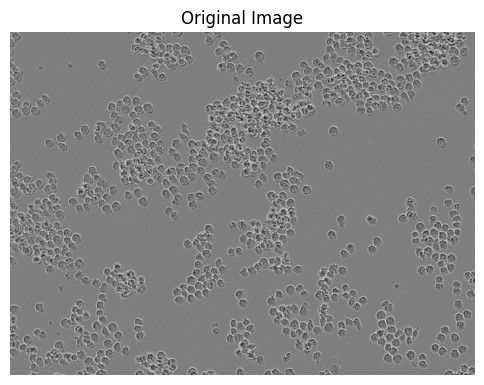

In [ ]:
# example image path (change this to your preprocessed image)
img_path = "/content/drive/MyDrive/DIP_Grp_5/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_D4_1_01d08h00m_4.tif"

# read the image in grayscale
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [ ]:
# params = [(0.5, (8,8)), (1.0, (16,16)), (2.0, (8,8)), (2.0, (16,16)), (3.0, (8,8))]

# plt.figure(figsize=(15,8))
# for i, (clip, grid) in enumerate(params, 1):
#     clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=grid)
#     img_clahe = clahe.apply(img)
#     plt.subplot(2, 3, i)
#     plt.imshow(img_clahe, cmap='gray')
#     plt.title(f"clip={clip}, grid={grid}")
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

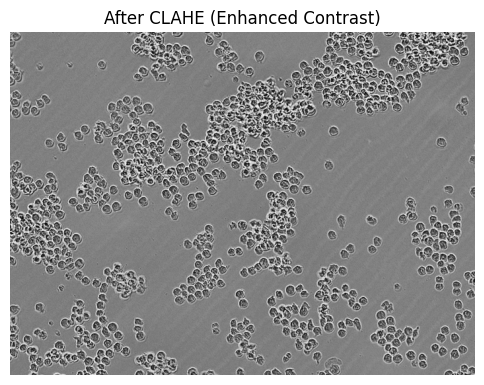

In [ ]:
# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img)

plt.figure(figsize=(6,6))
plt.imshow(img_clahe, cmap='gray')
plt.title("After CLAHE (Enhanced Contrast)")
plt.axis('off')
plt.show()

# Replace original 'img' with enhanced version for next steps
img = img_clahe

In [ ]:
# for k in [3,5,7,9]:
#     blurred = cv2.GaussianBlur(img, (k,k), 0)
#     plt.imshow(blurred, cmap='gray')
#     plt.title(f"Kernel Size = ({k},{k})")
#     plt.axis('off')
#     plt.show()

In [ ]:
# for sigma in [0.5, 1.0, 1.5, 2.0]:
#     blurred = cv2.GaussianBlur(img, (5,5), sigma)
#     plt.imshow(blurred, cmap='gray')
#     plt.title(f"SigmaX = {sigma}")
#     plt.axis('off')
#     plt.show()

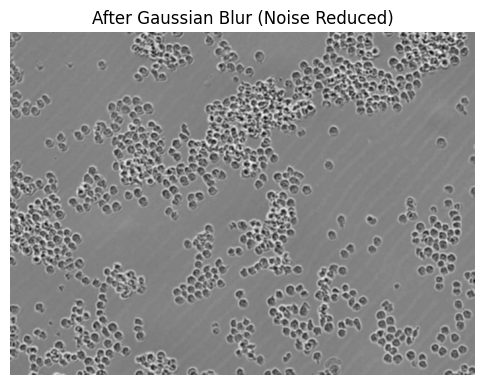

In [ ]:
# apply Gaussian Blur to smooth noise while keeping edges soft
blurred = cv2.GaussianBlur(img, (5,5), 0)

plt.figure(figsize=(6,6))
plt.imshow(blurred, cmap='gray')
plt.title("After Gaussian Blur (Noise Reduced)")
plt.axis('off')
plt.show()

In [ ]:
# for method in [cv2.ADAPTIVE_THRESH_MEAN_C, cv2.ADAPTIVE_THRESH_GAUSSIAN_C]:
#     t = cv2.adaptiveThreshold(blurred, 255, method,
#                               cv2.THRESH_BINARY_INV, 11, 10)
#     plt.imshow(t, cmap='gray')
#     plt.title("MEAN_C" if method==cv2.ADAPTIVE_THRESH_MEAN_C else "GAUSSIAN_C")
#     plt.axis('off')
#     plt.show()

In [ ]:
# for b in [15, 31, 51, 81, 101]:
#     t = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
#                               cv2.THRESH_BINARY_INV, b, 10)
#     plt.imshow(t, cmap='gray')
#     plt.title(f"blockSize = {b}")
#     plt.axis('off')
#     plt.show()

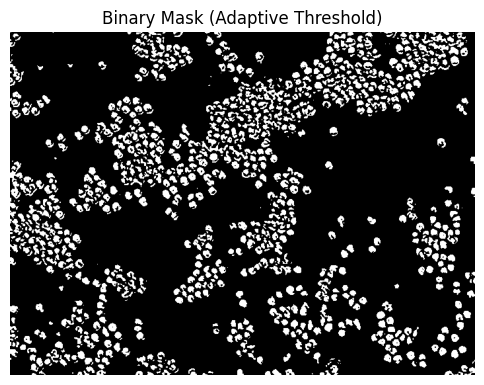

In [ ]:
# apply adaptive thresholding to separate foreground (cells) from background
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 101, 10)

plt.figure(figsize=(6,6))
plt.imshow(thresh, cmap='gray')
plt.title("Binary Mask (Adaptive Threshold)")
plt.axis('off')
plt.show()

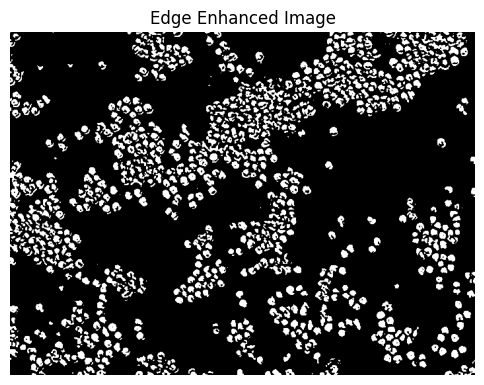

In [ ]:
# Apply Laplacian for edge enhancement
lap = cv2.Laplacian(thresh, cv2.CV_64F)
lap = cv2.convertScaleAbs(lap)
edge_enhanced = cv2.addWeighted(thresh, 1.5, lap, -0.5, 0)

plt.figure(figsize=(6,6))
plt.imshow(edge_enhanced, cmap='gray')
plt.title("Edge Enhanced Image")
plt.axis('off')
plt.show()

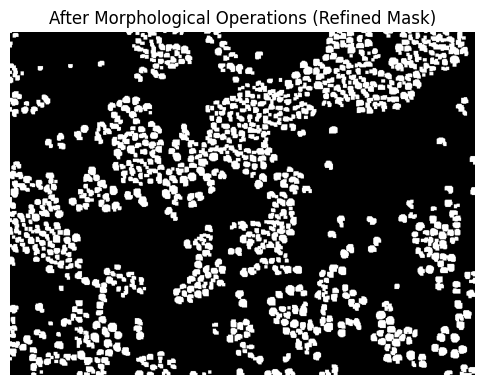

In [ ]:
# remove small noise and fill small holes
kernel = np.ones((3,3), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
cleaned = cv2.dilate(cleaned, kernel, iterations=1)

plt.figure(figsize=(6,6))
plt.imshow(cleaned, cmap='gray')
plt.title("After Morphological Operations (Refined Mask)")
plt.axis('off')
plt.show()

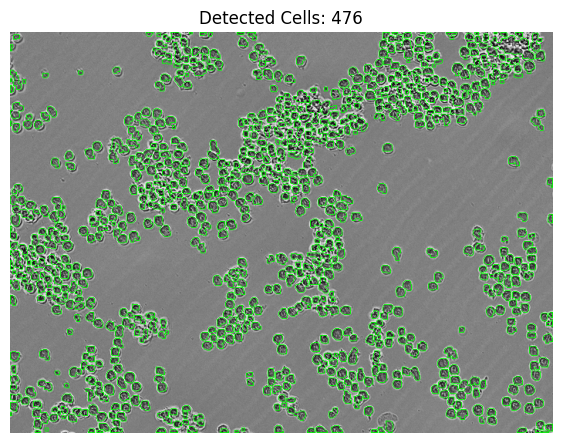

In [ ]:
# Find contours (boundaries of objects)
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a color copy to visualize
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw only contours (no boxes or text)
valid_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 5:  # filter very small objects
        valid_contours.append(cnt)
        cv2.drawContours(output, [cnt], -1, (0,255,0), 1)  # green contour

# Count valid contours
cell_count = len(valid_contours)

# Display
plt.figure(figsize=(7,7))
plt.imshow(output)
plt.title(f"Detected Cells: {cell_count}")
plt.axis('off')
plt.show()

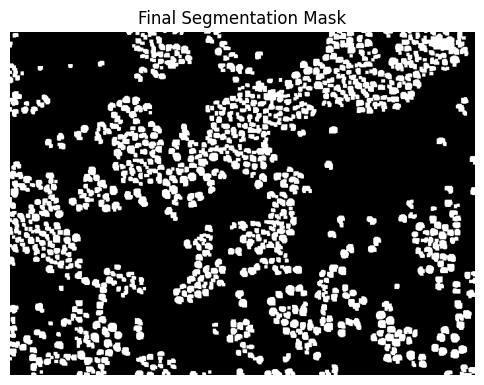

In [ ]:
# create blank mask to visualize segmentation
seg_mask = np.zeros_like(img)

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 5:
        cv2.drawContours(seg_mask, [cnt], -1, 255, -1)  # filled region

plt.figure(figsize=(6,6))
plt.imshow(seg_mask, cmap='gray')
plt.title("Final Segmentation Mask")
plt.axis('off')
plt.show()


In [ ]:
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix

# --- Paths to your images ---
ground_truth_path = "/content/drive/MyDrive/DIP_Grp_5/LIVECell_dataset_2021/annotations/LIVECell/BV2_images/BV2_Phase_D4_1_01d08h00m_4.tif"
# predicted_path = "/path/to/predicted_mask.tif"

# --- Read images as grayscale ---
gt = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
#pred = cv2.imread(predicted_path, cv2.IMREAD_GRAYSCALE)
pred = seg_mask

# --- Resize predicted if needed ---
if gt.shape != pred.shape:
    pred = cv2.resize(pred, (gt.shape[1], gt.shape[0]))

# --- Binarize both images (0 and 1) ---
_, gt_bin = cv2.threshold(gt, 127, 1, cv2.THRESH_BINARY)
_, pred_bin = cv2.threshold(pred, 127, 1, cv2.THRESH_BINARY)

# --- Flatten for metric calculation ---
gt_flat = gt_bin.flatten()
pred_flat = pred_bin.flatten()

# --- Confusion Matrix ---
tn, fp, fn, tp = confusion_matrix(gt_flat, pred_flat).ravel()

# --- Metrics ---
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp + 1e-8)
recall = tp / (tp + fn + 1e-8)
f1_score = 2 * precision * recall / (precision + recall + 1e-8)
iou = tp / (tp + fp + fn + 1e-8)
dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)

print("✅ Segmentation Performance Metrics:")BV2_Phase_B4_1_02d08h00m_2
print(f"Accuracy   : {accuracy * 100:.2f}%")
print(f"Precision  : {precision * 100:.2f}%")
print(f"Recall     : {recall * 100:.2f}%")
print(f"F1-score   : {f1_score * 100:.2f}%")
print(f"IoU (Jaccard): {iou * 100:.2f}%")
print(f"Dice Coefficient: {dice * 100:.2f}%")

plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(gt, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted Result
plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# --- Display ---
plt.tight_layout()
plt.show()

NameError: name 'seg_mask' is not defined

Entire Code

✅ Segmentation Performance Metrics:
Accuracy   : 88.65%
Precision  : 74.73%
Recall     : 69.98%
F1-score   : 72.27%
IoU (Jaccard): 56.59%
Dice Coefficient: 72.27%


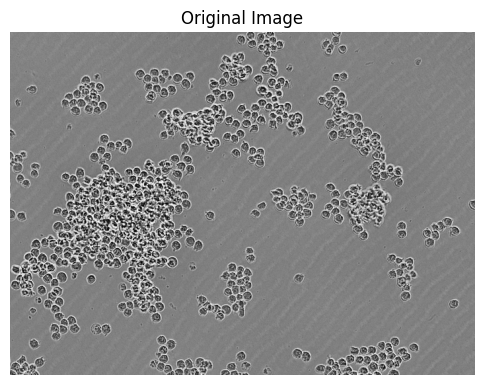

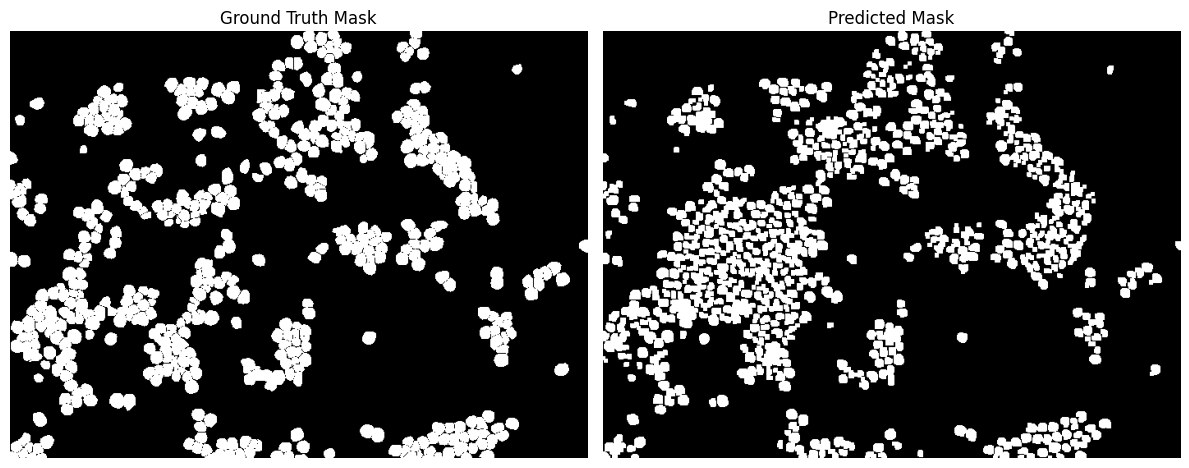

In [ ]:
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from skimage import exposure, filters, morphology, util

#img_path = "/content/drive/MyDrive/DIP_Grp_5/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_D4_1_01d08h00m_1.tif"
img_path = "/content/drive/MyDrive/DIP_Grp_5/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_B4_1_01d20h00m_3.tif"
#img_path = "/content/drive/MyDrive/DIP_Grp_5/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/BV2_Phase_C4_1_01d16h00m_3.tif"


# Original Image
plt.subplots(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# read the image in grayscale
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img)
# Replace original 'img' with enhanced version for next steps
img = img_clahe


# apply Gaussian Blur to smooth noise while keeping edges soft
blurred = cv2.GaussianBlur(img, (5,5), 0)

# apply adaptive thresholding to separate foreground (cells) from background
# thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 101, 10)

thresh = cv2.adaptiveThreshold(blurred, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,   # smoother for microscopy
                               cv2.THRESH_BINARY_INV,
                               71,   # smaller block = catches faint cells
                               5)    # lower C = more sensitivity


# Apply Laplacian for edge enhancement
lap = cv2.Laplacian(thresh, cv2.CV_64F)
lap = cv2.convertScaleAbs(lap)
edge_enhanced = cv2.addWeighted(thresh, 1.5, lap, -0.5, 0)

# remove small noise and fill small holes
kernel = np.ones((3,3), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
cleaned = cv2.dilate(cleaned, kernel, iterations=1)


#------------------------------------------
# # Improve filled cell shapes using distance transform reconstruction
# dist = cv2.distanceTransform(cleaned, cv2.DIST_L2, 5)
# dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)

# # Re-threshold based on distance (keeps cell interiors)
# _, dist_bin = cv2.threshold((dist_norm*255).astype("uint8"),
#                             0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# # Merge with your cleaned mask
# seg_mask = cv2.bitwise_or(cleaned, dist_bin)
#------------------------------------------------

# Find contours (boundaries of objects)
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a color copy to visualize
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw only contours (no boxes or text)
valid_contours = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 5:  # filter very small objects
        valid_contours.append(cnt)
        cv2.drawContours(output, [cnt], -1, (0,255,0), 1)  # green contour
# Count valid contours
cell_count = len(valid_contours)

# create blank mask to visualize segmentation
final_mask = np.zeros_like(img)

for cnt in contours:
    area = cv2.contourArea(cnt)
    # if area > 5:
    if 20 < area < 20000:
        cv2.drawContours(final_mask, [cnt], -1, 255, -1)  # filled region


# --- Paths to your images ---
ground_truth_path = "/content/drive/MyDrive/DIP_Grp_5/LIVECell_dataset_2021/annotations/LIVECell/BV2_images/BV2_Phase_B4_1_01d20h00m_3.tif"
# predicted_path = "/path/to/predicted_mask.tif"

# --- Read images as grayscale ---
gt = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
#pred = cv2.imread(predicted_path, cv2.IMREAD_GRAYSCALE)
pred = final_mask

# --- Resize predicted if needed ---
if gt.shape != pred.shape:
    pred = cv2.resize(pred, (gt.shape[1], gt.shape[0]))

# --- Binarize both images (0 and 1) ---
_, gt_bin = cv2.threshold(gt, 127, 1, cv2.THRESH_BINARY)
_, pred_bin = cv2.threshold(pred, 127, 1, cv2.THRESH_BINARY)

# --- Flatten for metric calculation ---
gt_flat = gt_bin.flatten()
pred_flat = pred_bin.flatten()

# --- Confusion Matrix ---
tn, fp, fn, tp = confusion_matrix(gt_flat, pred_flat).ravel()

# --- Metrics ---
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp + 1e-8)
recall = tp / (tp + fn + 1e-8)
f1_score = 2 * precision * recall / (precision + recall + 1e-8)
iou = tp / (tp + fp + fn + 1e-8)
dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)

print("Segmentation Performance Metrics:")
print(f"Accuracy   : {accuracy * 100:.2f}%")
print(f"Precision  : {precision * 100:.2f}%")
print(f"Recall     : {recall * 100:.2f}%")
print(f"F1-score   : {f1_score * 100:.2f}%")
print(f"IoU (Jaccard): {iou * 100:.2f}%")
print(f"Dice Coefficient: {dice * 100:.2f}%")

plt.figure(figsize=(12, 5))

# Ground Truth
plt.subplot(1, 2, 1)
plt.imshow(gt, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted Result
plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# --- Display ---
plt.tight_layout()
plt.show()

Over entire folder

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
from skimage import exposure, morphology

# -----------------------------------------------
# FOLDERS (CHANGE THESE)
# -----------------------------------------------
original_folder = "/content/drive/MyDrive/DIP_Grp_5/LIVECell_dataset_2021/images/livecell_train_val_images/BV2/"
gt_folder = "/content/drive/MyDrive/DIP_Grp_5/LIVECell_dataset_2021/annotations/LIVECell/BV2_images/"
output_mask_folder = "/content/drive/MyDrive/DIP_Grp_5/LIVECell_dataset_2021/predicted_masks/"

os.makedirs(output_mask_folder, exist_ok=True)

# -----------------------------------------------
# FUNCTION: Process one image
# -----------------------------------------------
def process_image(img):

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Gaussian Blur
    blurred = cv2.GaussianBlur(img, (5,5), 0)

    # Adaptive Threshold
    thresh = cv2.adaptiveThreshold(
        blurred, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        71, 5
    )

    # Morphology
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.dilate(cleaned, kernel, iterations=1)

    # Improve filled shapes using Distance Transform
    dist = cv2.distanceTransform(cleaned, cv2.DIST_L2, 5)
    dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)
    _, dist_bin = cv2.threshold((dist_norm*255).astype("uint8"),
                                0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    seg_mask = cv2.bitwise_or(cleaned, dist_bin)

    # Contours
    contours, _ = cv2.findContours(seg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    final_mask = np.zeros_like(img)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 20 < area < 20000:
            cv2.drawContours(final_mask, [cnt], -1, 255, -1)

    return final_mask


# -----------------------------------------------
# FUNCTION: Calculate metrics for one pair
# -----------------------------------------------
def compute_metrics(gt, pred):
    if gt.shape != pred.shape:
        pred = cv2.resize(pred, (gt.shape[1], gt.shape[0]))

    _, gt_bin = cv2.threshold(gt, 127, 1, cv2.THRESH_BINARY)
    _, pred_bin = cv2.threshold(pred, 127, 1, cv2.THRESH_BINARY)

    gt_flat = gt_bin.flatten()
    pred_flat = pred_bin.flatten()

    tn, fp, fn, tp = confusion_matrix(gt_flat, pred_flat).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)
    dice = (2 * tp) / (2 * tp + fp + fn + 1e-8)

    return accuracy, precision, recall, f1, iou, dice


# -----------------------------------------------
# MAIN LOOP — PROCESS ALL IMAGES
# -----------------------------------------------
results = []

for file in os.listdir(original_folder):
    if file.endswith(".tif") :

        img_path = os.path.join(original_folder, file)
        gt_path = os.path.join(gt_folder, file)

        if not os.path.exists(gt_path):
            print(f"⚠ No GT found for {file}, skipping.")
            continue

        print(f"Processing: {file}")

        # Load images
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        # Predict mask
        pred_mask = process_image(img)

        # Save predicted mask
        output_path = os.path.join(output_mask_folder, file)
        cv2.imwrite(output_path, pred_mask)

        # Metrics
        accuracy, precision, recall, f1, iou, dice = compute_metrics(gt, pred_mask)

        results.append([file, accuracy, precision, recall, f1, iou, dice])


# -----------------------------------------------
# SAVE RESULTS TO EXCEL
# -----------------------------------------------
df = pd.DataFrame(results, columns=[
    "Image Name", "Accuracy", "Precision", "Recall", "F1-score", "IoU", "Dice"
])

excel_path = "/content/drive/MyDrive/DIP_Grp_5/LIVECell_dataset_2021/segmentation_results.xlsx"
df.to_excel(excel_path, index=False)

print(f"\nALL DONE! Results saved to:\n➡ {excel_path}")
print(f"Predicted masks saved in:\n➡ {output_mask_folder}")


Processing: BV2_Phase_B4_1_00d00h00m_4.tif
Processing: BV2_Phase_B4_1_00d00h00m_2.tif
Processing: BV2_Phase_B4_1_00d00h00m_1.tif
Processing: BV2_Phase_B4_1_00d04h00m_1.tif
Processing: BV2_Phase_B4_1_00d00h00m_3.tif
⚠ No GT found for BV2_Phase_B4_1_01d08h00m_4.tif, skipping.
⚠ No GT found for BV2_Phase_B4_1_00d08h00m_2.tif, skipping.
⚠ No GT found for BV2_Phase_B4_1_01d08h00m_3.tif, skipping.
Processing: BV2_Phase_B4_1_00d16h00m_2.tif
Processing: BV2_Phase_B4_1_01d08h00m_1.tif
Processing: BV2_Phase_B4_1_00d12h00m_3.tif
Processing: BV2_Phase_B4_1_01d04h00m_4.tif
Processing: BV2_Phase_B4_1_01d12h00m_1.tif
Processing: BV2_Phase_B4_1_00d16h00m_1.tif
Processing: BV2_Phase_B4_1_00d04h00m_2.tif
⚠ No GT found for BV2_Phase_B4_1_01d12h00m_3.tif, skipping.
⚠ No GT found for BV2_Phase_B4_1_01d04h00m_3.tif, skipping.
Processing: BV2_Phase_B4_1_01d00h00m_4.tif
Processing: BV2_Phase_B4_1_00d08h00m_4.tif
Processing: BV2_Phase_B4_1_00d20h00m_3.tif
Processing: BV2_Phase_B4_1_01d04h00m_1.tif
Processing: 